In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim

from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets,transforms

https://www.kaggle.com/c/dogs-vs-cats/data

In [2]:
dataset = datasets.ImageFolder(root ='train/',
                               transform=transforms.Compose([transforms.Resize(256),
                                                             transforms.ColorJitter(),
                                                             transforms.RandomCrop(224),
                                                             transforms.RandomHorizontalFlip(),
                                                             transforms.Resize(128),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                               ]))

train_set, val_set = torch.utils.data.random_split(dataset,[int(len(dataset)*0.8),int(len(dataset)*0.2)])

train_dataloader = DataLoader(train_set,batch_size=1024,
                        shuffle=True,num_workers=8,
                        drop_last=True,pin_memory=True)

val_dataloader = DataLoader(val_set)

In [3]:
class My_ResNet(nn.Module):
    def __init__(self):
        super(My_ResNet,self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(3,4,kernel_size=3,padding=1), # [batchsize,3,128,128] -> [batchsize,4,128,128]
        nn.ReLU(),
        nn.MaxPool2d(2,2), # [batchsize,4,128,128] -> [batchsize,4,64,64]
        
        nn.Conv2d(4,8,kernel_size=3,padding=1), # [batchsize,4,64,64] -> [batchsize,8,64,64]
        nn.ReLU(),
        nn.Conv2d(8,16,kernel_size=3,padding=1), # [batchsize,8,64,64] -> [batchsize,16,64,64]
        nn.ReLU(),
        nn.MaxPool2d(2,2)) # [batchsize,16,64,64] -> [batchsize,16,32,32]
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(16,8,kernel_size=1,padding=16), # [batchsize,16,32,32] -> [batchsize,8,64,64]
        nn.ReLU(),
        nn.Conv2d(8,3,kernel_size=1,padding=32), # [batchsize,8,64,64] -> [batchsize,3,128,128]
        nn.ReLU())
        
        self.layer3 = nn.Sequential(
        nn.Conv2d(3,4,kernel_size=3,padding=1), # [batchsize,3,128,128] -> [batchsize,4,128,128]
        nn.ReLU(),
        nn.MaxPool2d(2,2), # [batchsize,4,128,128] -> [batchsize,4,64,64]
            
        nn.Conv2d(4,8,kernel_size=3,padding=1), # [batchsize,4,64,64] -> [batchsize,8,64,64]
        nn.ReLU(),
        nn.Conv2d(8,16,kernel_size=3,padding=1), # [batchsize,8,64,64] -> [batchsize,16,64,64]
        nn.ReLU(),
        nn.MaxPool2d(2,2)) # [batchsize,16,64,64] -> [batchsize,16,32,32]
        
        
        self.fc_layer = nn.Sequential(
        nn.Linear(16*32*32,128),
        nn.ReLU(),
        nn.Linear(128,2))
    
    def forward(self,x):
        init_x = x
        out = self.layer1(x)
        out = self.layer2(out)+init_x
        out = self.layer3(out)
        out = out.view(x.size(0),-1)
        out = self.fc_layer(out)
        return nn.LogSoftmax(dim=1)(out)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = My_ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

epochs = 50

In [5]:
plot_list = {'train':[],'val':[],'accuracy':[]}

for epoch in range(epochs):
    
    model.train()
    train_losses = []
    for i,data in enumerate(train_dataloader):
        inputs,targets = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs.detach())
        train_loss = criterion(outputs,targets)
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.detach()) ## train_loss를 detach하지않으면 gpu에 계속 남아서 메모리를 잡아먹음...
                                                 ## 진짜 애많이먹었습니다....
                                                 ## data와 inputs도 혹시모르니...삭제
        del data
        del inputs
        
    
    val_losses = []
    correct = 0
    model.eval()
    for data in val_dataloader:
        inputs,targets = data[0].to(device), data[1].to(device)

        outputs = model(inputs)
        val_loss = criterion(outputs,targets)
        val_losses.append(val_loss.detach())

        prob,label = torch.exp(outputs).topk(1,dim=1)
        if targets==label.view(1):
            correct+=1
        del data
        del inputs
    val_accuracy = correct/len(val_set)
    
    print(f"{epoch+1} epoch train loss = {sum(train_losses)/len(train_losses)}")
    print(f"{epoch+1} epoch val loss = {sum(val_losses)/len(val_losses)}")
    print(f"{epoch+1} epoch accuracy = {val_accuracy}")
    print('--------------------------------------------------')
    plot_list['train'].append(sum(train_losses)/len(train_losses))
    plot_list['val'].append(sum(val_losses)/len(val_losses))
    plot_list['accuracy'].append(val_accuracy)
    
#     if epoch < 11:continue
#     if sum(plot_list['val'][-11:-6])/5 < sum(val_losses)/len(val_losses):
#         print(f'over_fitting is occured at {epoch} epoch')
#         break
        

1 epoch train loss = 0.7201133370399475
1 epoch val loss = 0.6770513653755188
1 epoch accuracy = 0.608
--------------------------------------------------
2 epoch train loss = 0.6607891321182251
2 epoch val loss = 0.6376243829727173
2 epoch accuracy = 0.6482
--------------------------------------------------
3 epoch train loss = 0.6309545040130615
3 epoch val loss = 0.6279294490814209
3 epoch accuracy = 0.6494
--------------------------------------------------
4 epoch train loss = 0.6207672357559204
4 epoch val loss = 0.6085058450698853
4 epoch accuracy = 0.675
--------------------------------------------------
5 epoch train loss = 0.6107932925224304
5 epoch val loss = 0.6097381711006165
5 epoch accuracy = 0.6696
--------------------------------------------------
6 epoch train loss = 0.6059317588806152
6 epoch val loss = 0.598031222820282
6 epoch accuracy = 0.679
--------------------------------------------------
7 epoch train loss = 0.5967373847961426
7 epoch val loss = 0.5849795937538

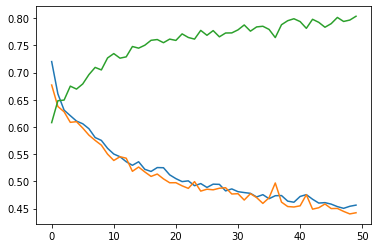

In [7]:
import matplotlib.pyplot as plt
plt.plot(plot_list['train'])
plt.plot(plot_list['val'])
plt.plot(plot_list['accuracy'])
plt.show()